In [148]:
import utils
import pandas as pd
import numpy as np
from x import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [2]:
qa_df = pd.read_json('../data/ms_macro_qa/dev_v2.1.json')

In [ ]:
with open('../data/ms_macro_qa/train_v2.1.json', 'r') as f:
    for l in f.readlines()[:10]:
        print(l)

In [3]:
qa_df.shape

(101093, 6)

In [5]:
qa_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,[A corporation is a company or group of people...,"[{'is_selected': 0, 'passage_text': 'A company...",. what is a corporation?,1102432,DESCRIPTION,[]
1,[Rachel Carson writes The Obligation to Endure...,"[{'is_selected': 0, 'passage_text': 'Read to w...",why did rachel carson write an obligation to e...,1102431,DESCRIPTION,[]
10,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'The Progr...",why did the progressive movement fail to advan...,1102421,DESCRIPTION,[]
100,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'On an ave...",why do police need to understand what the fore...,1102315,DESCRIPTION,[]
1000,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'A: Very, ...",do owls eat in the day,1101280,NUMERIC,[]


In [6]:
qa_df.sample(100)

,answers,passages,query,query_id,query_type,wellFormedAnswers
27394,[Scott Ling. Dr Scott Ling's Chinese Medicine ...,"[{'is_selected': 0, 'passage_text': 'View Scot...",where is sustain health practice scott ling,997744,LOCATION,[]
68203,[1-3 years],"[{'is_selected': 0, 'passage_text': 'A bachelo...",how much longer after bachelors does a masters...,323946,NUMERIC,"[Masters take 1 to 3 years after Bachelors., A..."
40994,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'History o...",is grand jury considered a civil jury,411480,DESCRIPTION,[]
63911,[Disturbance in either the balance organs of t...,"[{'is_selected': 0, 'passage_text': 'Vertigo i...",what are some causes of vertigo,565231,DESCRIPTION,[]
43752,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'Basic con...",alaskan slab cost,15164,NUMERIC,[]
36432,[36 to 42 islands.],"[{'is_selected': 0, 'passage_text': 'For more ...",how many islands in ny,286709,NUMERIC,[]
7200,[JUMP Math is a numeracy program and it is ded...,"[{'is_selected': 0, 'passage_text': 'Math expl...",jump definition in math,1093729,DESCRIPTION,[]
78571,[40 mg before anxious situations or twice a day.],"[{'is_selected': 0, 'passage_text': 'Possible ...",what is the dosage for propranolol for anxiety,819416,DESCRIPTION,[]
86988,"[2 hours, 58 minutes.]","[{'is_selected': 0, 'passage_text': 'And as th...",what is the average length of a major league b...,806448,NUMERIC,[]
69317,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'Your Last...",does i input jr in first name or last name on ...,167397,DESCRIPTION,[]


## Transform the questions into half of the feature space

In [15]:
questions = qa_df.loc[:, 'query']

In [17]:
questions[:10]

0                                  . what is a corporation?
1         why did rachel carson write an obligation to e...
10        why did the progressive movement fail to advan...
100       why do police need to understand what the fore...
1000                                 do owls eat in the day
10000                             symptoms of a dying mouse
100000          average number of lightning strikes per day
100001               can you burn your lawn with fertilizer
100002              are volvox autotrophic or heterotrophic
100003                          average force of a raindrop
Name: query, dtype: object

In [20]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer


In [25]:
## text transformation pipes
# clean_text = Pipeline(
#     [
#         ('stack', FunctionTransformer(utils.stack_questions, validate=False)),

#     ]
# )

# lemma_text = Pipeline(
#     [
#         ('lemma', FunctionTransformer(utils.apply_lemma, validate=False))
#     ]
# )

# # feature engineering pipes
# single_question_pipe = Pipeline(
#     [
#         ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False)),
# #         ('unstack', FunctionTransformer(utils.unstack_questions, validate=False))
#     ]
# )

# No Pairs
# pair_question_pipe = Pipeline(
#     [
#         ('ngram_sim', FunctionTransformer(utils.calc_ngram_similarity, kw_args={'n_grams':[1, 2, 3]}, validate=False))
#     ]
# )

# build features on the cleaned text only
clean_text_features = Pipeline(
    [
        ('clean', FunctionTransformer(utils.clean_questions, validate=False)),
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False))
    ]
)

# build features on the cleanned and lemmatized text features
lemma_text_features = Pipeline(
    [
        ('clean', FunctionTransformer(utils.clean_questions, validate=False)),
        ('lemma', FunctionTransformer(utils.apply_lemma, validate=False)),
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False))
    ]
)

# pre-process pipe
feature_transformation = Pipeline(
    [
        ('feats', FeatureUnion(
            [
                ('clean_text_features', clean_text_features),
                ('lemma_text_features', lemma_text_features)
            ]
        ))
    ]
)


In [140]:
%%time
q_trans_clean = clean_text_features.transform(questions)

CPU times: user 2min 59s, sys: 16 s, total: 3min 15s
Wall time: 4min 4s


In [141]:
q_trans_clean.shape

(101093, 9)

In [142]:
%%time
q_trans_lemma = lemma_text_features.transform(questions)

CPU times: user 3min 39s, sys: 36.9 s, total: 4min 16s
Wall time: 5min 4s


In [143]:
q_trans_lemma.shape

(101093, 9)

In [144]:
utils.save(q_trans_clean, 'transformed_questions_clean')
utils.save(q_trans_lemma, 'transformed_questions_lemma')

In [78]:
%%time
cleaned_questions = utils.clean_questions(questions)

CPU times: user 1.01 s, sys: 72.9 ms, total: 1.08 s
Wall time: 1.39 s


In [82]:
df_cleaned_questions = pd.DataFrame(cleaned_questions)
df_cleaned_questions = df_cleaned_questions.rename(columns={0:'question1'})
df_cleaned_questions['id'] = df_cleaned_questions.index
df_cleaned_questions.head()

,question1,id
0,what is a corporation,0
1,why did rachel carson write an obligation to e...,1
2,why did the progressive movement fail to advan...,2
3,why do police need to understand what the fore...,3
4,do owls eat in the day,4


In [190]:
xgb = utils.load('xgb_FINAL_model')
feature_pipe = utils.load('feature_pipe')

In [256]:
def ask_question(question):
    
    ## if question is a duplicate after cleaning, then return the answer
    ## else run the model
    
#     ## Feature Set 1 -- clean text similarity
#     # calculate n_gram similarity for the cleaned question
#     question_clean = utils.clean_questions(question)
#     doc = utils.nlp(question_clean[0])
#     question_tokens = doc.to_array([utils.spacy.attrs.LOWER])
#     clean_n_gram = ngram_similarity(q_tokens)

#     ## Feature Set 2 -- Clean distance features
#     # union single question features
#     question_features = clean_text_features.transform([question]) 
#     clean_single_features = np.hstack([q_trans_clean, np.repeat(question_features, q_trans_clean.shape[0], axis=0)])

#     ## Feature Set 3 -- Lemma text similarity
#     # calculate n_gram similarity for the cleaned and lemmatized question
#     question_lemma = utils.apply_lemma(question_clean)
#     doc = utils.nlp(question_lemma[0])
#     question_tokens = doc.to_array([utils.spacy.attrs.LOWER])
#     lemma_n_gram = ngram_similarity(q_tokens)

#     ## Feature Set 4 -- Lemma distance features
#     # union single question features
#     question_features = lemma_text_features.transform([question]) 
#     lemma_single_features = np.hstack([q_trans_lemma, np.repeat(question_features, q_trans_lemma.shape[0], axis=0)])

    ### Transform through the whole pipeline
    df_cleaned_questions['question2'] = question
    
    feature_space = feature_pipe.transform(df_cleaned_questions[:5000])

    ## make the prediction
#     feature_space = np.hstack([clean_n_gram, clean_single_features, lemma_n_gram, lemma_single_features])
    probs = xgb.predict_proba(feature_space)[:, 1]
    
    top = probs.argsort()[-3:]
    top_question = np.array(questions.iloc[top]).reshape(-1, 1)
    top_probs = probs[top].reshape(-1, 1)
    
#     return pd.DataFrame(np.hstack([top_question, top_probs]))
    return df_cleaned_questions, feature_space, pd.DataFrame(np.hstack([top_question, top_probs]))

In [257]:
df, features, top_results = ask_question('do owls eat at night')

In [250]:
df[df.question1 == 'do owls eat in the day']

,question1,id,question2
4,do owls eat in the day,4,do owls eat in the day


In [258]:
top_results

,0,1
0,do spiders eat other animals,0.288564
1,what causes swelling in hands at night,0.30395
2,do owls eat in the day,0.347248


In [251]:
features[4]

array([  1.        ,   1.        ,   1.        ,   4.63359628,
         8.4752183 ,   6.82304781,   0.44451424,   0.94712703,
         0.66871357,  62.24226321, 115.15204134,  92.26256858,
         4.63359628,   8.4752183 ,   6.82304781,   0.44451424,
         0.94712703,   0.66871357,  62.24226321, 115.15204134,
        92.26256858,   1.        ,   1.        ,   1.        ,
         6.72955502,   8.34001638,   7.60125726,   0.55986509,
         0.79268708,   0.69988742,  92.72933482, 111.52220958,
       102.69947146,   6.72955502,   8.34001638,   7.60125726,
         0.55986509,   0.79268708,   0.69988742,  92.72933482,
       111.52220958, 102.69947146])

In [214]:
probs = xgb.predict_proba(features)[:, 1]

In [218]:
xgb.predict_proba(features[20546].reshape(1, -1))[:, 1]

array([0.1619365], dtype=float32)

In [216]:
probs[20546]

0.1619365

In [220]:
import matplotlib.pyplot as plt
print(xgb.feature_importances_)

[0.02938479 0.02320101 0.01954768 0.01709631 0.0290843  0.02475091
 0.02119247 0.03724498 0.03382888 0.01341136 0.02718646 0.02229954
 0.01790289 0.02774    0.02487743 0.0211134  0.03670726 0.03213665
 0.0142812  0.02740788 0.02233117 0.02340661 0.01603669 0.01205124
 0.02133481 0.02304286 0.02117666 0.02979598 0.03019137 0.02762929
 0.01991143 0.02397596 0.02027519 0.0207022  0.02217302 0.0199747
 0.02709157 0.03117191 0.02400759 0.01902578 0.02492488 0.01937371]


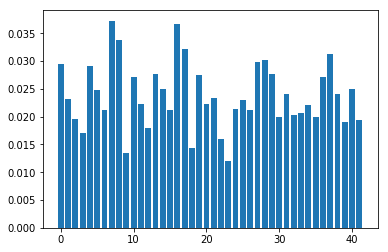

In [221]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

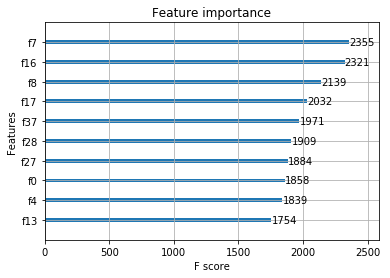

In [240]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=10)
plt.show()

In [236]:
feature_names = [
    'clean_1_gram_sim',
    'clean_2_gram_sim',
    'clean_3_gram_sim',
    'clean_euc_min_q1',
    'clean_euc_max_q1',
    'clean_euc_avg_q1',
    'clean_cos_min_q1',
    'clean_cos_max_q1',
    'clean_cos_avg_q1',
    'clean_man_min_q1',
    'clean_man_max_q1',
    'clean_man_avg_q1',
    'clean_euc_min_q2',
    'clean_euc_max_q2',
    'clean_euc_avg_q2',
    'clean_cos_min_q2',
    'clean_cos_max_q2',
    'clean_cos_avg_q2',
    'clean_man_min_q2',
    'clean_man_max_q2',
    'clean_man_avg_q2',
    'lemma_1_gram_sim',
    'lemma_2_gram_sim',
    'lemma_3_gram_sim',
    'lemma_euc_min_q1',
    'lemma_euc_max_q1',
    'lemma_euc_avg_q1',
    'lemma_cos_min_q1',
    'lemma_cos_max_q1',
    'lemma_cos_avg_q1',
    'lemma_man_min_q1',
    'lemma_man_max_q1',
    'lemma_man_avg_q1',
    'lemma_euc_min_q2',
    'lemma_euc_max_q2',
    'lemma_euc_avg_q2',
    'lemma_cos_min_q2',
    'lemma_cos_max_q2',
    'lemma_cos_avg_q2',
    'lemma_man_min_q2',
    'lemma_man_max_q2',
    'lemma_man_avg_q1'
    
]
print(len(feature_names))

42


In [253]:
def print_features(l=[7, 16, 8, 17, 37, 28, 27, 0, 4, 13]):
    for n in l:
#         print(n)
        print(feature_names[n])
print_features()

clean_cos_max_q1
clean_cos_max_q2
clean_cos_avg_q1
clean_cos_avg_q2
lemma_cos_max_q2
lemma_cos_max_q1
lemma_cos_min_q1
clean_1_gram_sim
clean_euc_max_q1
clean_euc_max_q2


In [238]:
features[20456, [7, 16, 8, 17, 37]]

array([0.96252071, 1.08482914, 0.72458074, 0.68943047, 1.06595845])

In [239]:
xgb.get_booster().get_fscore()

{'f1': 1467,
 'f21': 1480,
 'f0': 1858,
 'f28': 1909,
 'f7': 2355,
 'f29': 1747,
 'f6': 1340,
 'f8': 2139,
 'f12': 1132,
 'f4': 1839,
 'f16': 2321,
 'f2': 1236,
 'f27': 1884,
 'f17': 2032,
 'f39': 1203,
 'f22': 1014,
 'f13': 1754,
 'f18': 903,
 'f10': 1719,
 'f37': 1971,
 'f19': 1733,
 'f23': 762,
 'f38': 1518,
 'f34': 1402,
 'f5': 1565,
 'f24': 1349,
 'f3': 1081,
 'f25': 1457,
 'f32': 1282,
 'f41': 1225,
 'f15': 1335,
 'f35': 1263,
 'f20': 1412,
 'f26': 1339,
 'f31': 1516,
 'f33': 1309,
 'f9': 848,
 'f36': 1713,
 'f30': 1259,
 'f40': 1576,
 'f11': 1410,
 'f14': 1573}

In [ ]:
#### ask_question('What is the capital of Washington?')
# ask_question('noncontagious definition')
ask_question('where is the stamen located in a flower')

In [188]:
qa_df.loc[:, 'query'].sample()

27505    where is the stamen located in a flower
Name: query, dtype: object

In [167]:
p.argsort()[-3:]

array([21032, 80760, 14203])

In [166]:
questions.iloc[p.argsort()[-3:]]
# questions.iloc[1]

27943     which is the original delmonico's
81699               what state is borths in
21797    what is the meaning of the bowery?
Name: query, dtype: object

In [168]:
q_array = np.array(questions)

In [169]:
q_array[14203]

'what is the meaning of the bowery?'

In [170]:
q_array[80760]

'what state is borths in'

In [72]:
q = ['What is the capital of Washington?']

In [76]:
np.repeat(q, 2, axis=0).shape

(2,)

In [101]:
def tokenize_questions(X):
    texts = []
    for doc in utils.nlp.pipe(X, disable=['parser', 'ner'], batch_size=10000):
        texts.append(doc.to_array([utils.spacy.attrs.LOWER]))
    return texts

In [102]:
token_text = tokenize_questions(df_cleaned_questions.question1)

In [108]:
utils.save(token_text, 'questions_tokenized')


In [104]:
for t in token_text:
    print(type(t))
    break

<class 'numpy.ndarray'>


In [97]:
from nltk import ngrams

In [107]:
for n in ngrams(np.array(token_text[0]), 3, pad_right=True):
    print(n)

(8532415787641010193, 5865838185239622912, 3411606890003347522)
(5865838185239622912, 3411606890003347522, 11901859001352538922)
(3411606890003347522, 11901859001352538922, 14070511896034874754)
(11901859001352538922, 14070511896034874754, None)
(14070511896034874754, None, None)


In [111]:
doc = utils.nlp('What is the capital of Washington?')
q_tokens = doc.to_array([utils.spacy.attrs.LOWER])

In [116]:
np.hstack([np.array(token_text).reshape(-1, 1), np.repeat(q_tokens, len(token_text), axis=0).reshape(1, -1)]).shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [117]:
t = np.array(token_text).reshape(-1, 1)

In [118]:
t.shape

(101093, 1)

In [119]:
t

array([[array([ 8532415787641010193,  5865838185239622912,  3411606890003347522,
       11901859001352538922, 14070511896034874754], dtype=uint64)],
       [array([16315412628806490806, 13583488448875926965, 11779693057662023107,
        2619154345045139155, 15597474948775060119, 15099054000809333061,
        1920611397140219205,  3791531372978436496, 13569477888548814854],
      dtype=uint64)],
       [array([16315412628806490806, 13583488448875926965,  7425985699627899538,
       11900862162089982680,  6184037061712818460,  3142894986720291236,
        3791531372978436496, 17339002579355368042,  9095968958430269659,
       10313580197444822952,  9952569212994313472], dtype=uint64)],
       ...,
       [array([16331095434822636218, 12965068231793614765,  3791531372978436496,
        7340758616018961957, 10606469382566443026, 16929211676819693673],
      dtype=uint64)],
       [array([ 3077651023035088716,  6878210874361030284,  3791531372978436496,
       13320680580156776400, 1412212

In [127]:
v = np.repeat(q_tokens, len(token_text))

In [128]:
v.shape

(707651,)

In [124]:
len(token_text)

101093

In [131]:
def ngram_similarity(q_token, n_grams=[1, 2, 3]):
    ''' Calculates the ngram similarity between a pair of questions. Similarity is defined as,
            2 · ( |S1| / |S1 ∩ S2| + |S2| / |S1 ∩ S2|)^−1
        where S_i is the ngrams for question i
        
        X: array-like (n_pairs*2,)
        Array of questions with pairs in sequential order.
        
        n_grams: list
        List of n-grams to calculate, i.e. [1, 2, 3]
        
        return: array-like (n_pairs, len(n_grams))
        N-dimensional array of n_gram similarity calculated for the different n_grams.
        
    '''
    ngram_sim = []
    ngram_q2 = [set(ngrams(q_token, i, pad_right=True)) for i in n_grams]
    for t in token_text:
        ngram_q1 = [set(ngrams(t, i, pad_right=True)) for i in n_grams]

        doc_ngram_sim = []
        for i in range(len(ngram_q1)):
            try:
                s1 = len(ngram_q1[i]) / len(ngram_q1[i].intersection(ngram_q2[i]))
            except:
                s1 = 0

            try:
                s2 = len(ngram_q2[i]) / len(ngram_q1[i].intersection(ngram_q2[i]))
            except:
                s2 = 0

            if s1 == 0 and s2 == 0:
                doc_ngram_sim.append(0)
            else:
                doc_ngram_sim.append(2 * (s1 + s2)**-1)
        ngram_sim.append(doc_ngram_sim)
        
    return np.array(ngram_sim)


In [133]:
%%time
ngram_similarity(q_tokens)

CPU times: user 3.62 s, sys: 69 ms, total: 3.69 s
Wall time: 4.64 s


array([[0.33333333, 0.16666667, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.11111111, 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])